In [3]:
# Some R code for Chris Scarpone, rough template to create some synthetic data

In [17]:
# First just set things up, with a function and some parameters and library calls

correlatedVector = function(inVector, corCoef)
{
  # Function to create correlated dataset
  # Modified from https://stat.ethz.ch/pipermail/r-help/2007-April/128925.html
  x2 = scale(matrix(rnorm(length(inVector)), ncol=1))
  x12 = cbind(scale(inVector),x2)
  c1 = var(x12)
  chol1 = solve(chol(c1))
  newx =  x12 %*% chol1 
  newc = matrix(c(1, corCoef, corCoef, 1), ncol=2)
  chol2 = chol(newc)
  finalx = newx %*% chol2 * sd(inVector) + mean(inVector)
  apply(finalx, 2, sd)
  responseValues = finalx[,2]
  return(responseValues)
}

set.seed = (123324)  # To ensure reproducability

# Some parameters
ncol = 100
nrow = 100
nhills = 10
hillelevation = 100
hillsmooth = 15
noisevalue = 0.02
correlation = 0.7
nsamples = 100
gradientmax = 1

library(rgdal, verbose=FALSE)
library(raster, verbose=FALSE)
library(sp, verbose=FALSE)
library(MASS, verbose=FALSE)

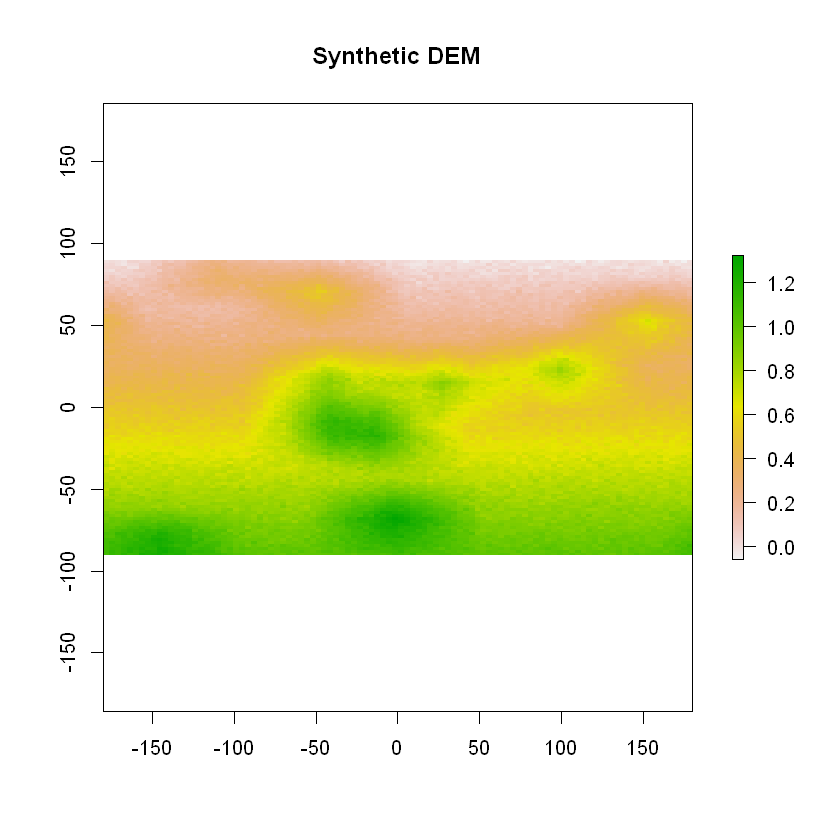

In [26]:
### 1) Create realistic DEM ###
# Base DEM
dem = raster(ncol=ncol, nrow=nrow)
values(dem) = rep(0, ncell(dem))

# Add north-south gradient
# Modified from https://gis.stackexchange.com/questions/311688/how-to-make-a-raster-gradient-in-any-direction-in-r
polymat = as.matrix(dem)
polymat = apply(polymat, 1, function(x) seq(0, gradientmax, length.out=ncol(dem))) 
dem = raster(polymat,
                  xmn = extent(dem)[1],
                  xmx = extent(dem)[2],
                  ymn = extent(dem)[3],
                  ymx = extent(dem)[4])

# Add hills
bbox = as(extent(dem), "SpatialPolygons")
p = spsample(bbox, n = nhills, type = "random")
h1 = rasterize(p, dem, field=hillelevation, background=0)
h2 = focal(h1, w=matrix(1, hillsmooth, hillsmooth), mean, pad=TRUE, padValue = 0)
h3 = focal(h2, w=matrix(1, hillsmooth, hillsmooth), mean, pad=TRUE, padValue = 0)
dem = dem + h3

# Add random noise (could add spatially autocorrelated noise to be more sophisticated)
noise = dem
values(noise) = rnorm(ncell(dem), mean=0, sd = noisevalue)
dem = dem + noise
                
# Plot the result to see that it looks ok
plot(dem, main="Synthetic DEM")

Correlation based on all cells: 0.7


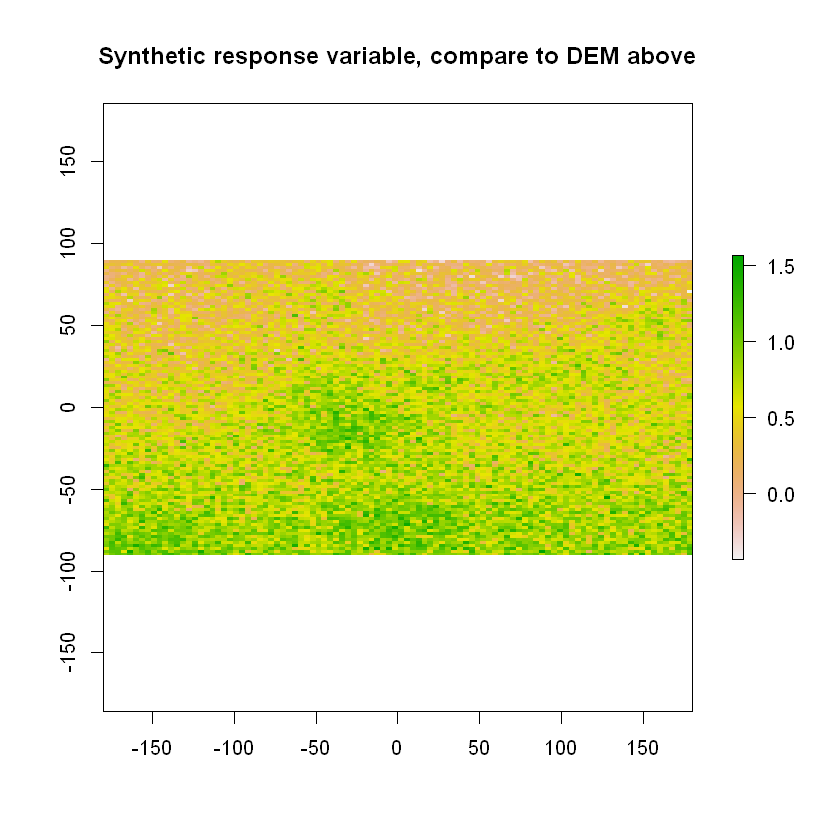

In [27]:
### 2) Create correlated data for response ###
demValues = values(dem)
responseValues = correlatedVector(demValues, correlation)
responseRaster = dem
values(responseRaster) = responseValues

# Plot response
plot(responseRaster, main="Synthetic response variable, compare to DEM above")

# Check that the correlation worked
cat(paste("Correlation based on all cells: " , as.character(cor(responseValues, demValues)), "\n", sep=""))

Correlation based on samples: 0.676624973825141


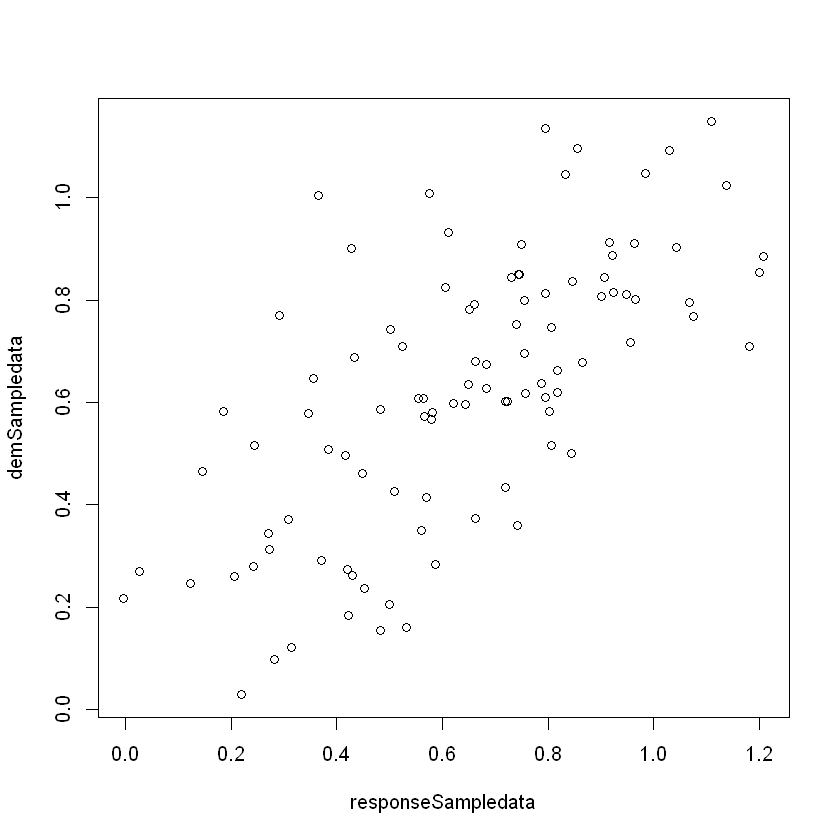

In [28]:
# Add sample points
p = spsample(bbox, n = nsamples, type = "random")
responseSampledata = extract(responseRaster, p)

# Check sample correlation with dem, should be similar to correlation
demSampledata = extract(dem, p)
# Check the correlation in the sample
cat(paste("Correlation based on samples: " , as.character(cor(responseSampledata, demSampledata)), "\n", sep=""))

# Plot the result to see that it looks ok
plot(responseSampledata, demSampledata)